<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Problem Statement </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<div style="margin: 20px; padding: 10px; border-left: 5px solid #2c3e50; background-color: #ecf0f1;">
    <p style="font-size: 16px; text-align: justify; color: #34495e;">
        In the Windy City - Chicago, where urban mobility is paramount for the daily commute and leisure activities of its residents, the <b>Cook County Planning and Development Department</b> seeks to optimize the city's bike-sharing program. With a dataset that includes historical records of bike rentals, weather conditions (temperature, humidity, wind speed), time (hour of the day, day of the week), and other variables, the challenge lies in developing a predictive model capable of forecasting bike rental demand. Accurate predictions will not only improve the efficiency of bike distribution across the city, enhancing user satisfaction, but also support Chicago's commitment to sustainable urban transportation.
    </p>
    <p style="font-size: 16px; text-align: justify; color: #34495e;">
        The goal is to harness machine learning techniques to analyze patterns within these variables and predict the number of bikes needed. By identifying the key factors influencing rental frequency, such as specific weather conditions that deter or encourage bike usage, or peak times indicating higher demand, this project aims to deliver actionable insights that ensure the availability of bikes, thereby reducing wait times and fostering a more reliable and user-friendly bike-sharing system.
    </p>
</div>


In [1]:
# Importing libraries
import pandas as pd # data science essentials
import matplotlib.pyplot as plt # essential graphical output
import seaborn as sns # enhanced graphical output
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

# specifying file name
file = './Chicago Bike Dataset/chicago_training_data.xlsx'

# reading the file into Python
bike = pd.read_excel(io = file)
bike.head()

,ID,DateHour,Temperature(F),Humidity(%),Wind speed (mph),Visibility(miles),DewPointTemperature(F),Rainfall(in),Snowfall(in),SolarRadiation(MJ/m2),Holiday,FunctioningDay,RENTALS
0,mb_1039,2023-10-14 05:59:55.000,52,81,0.4,2.9,46.4,0.0,0.0,0.00,No,Yes,519
1,mb_1330,2023-10-26 08:59:53.000,51,53,2.2,NaN,35.2,0.0,0.0,1.01,No,Yes,1251
2,mb_551,2023-09-23 21:59:57.000,56,49,2.5,3.4,38.8,0.0,0.0,0.00,No,Yes,1685
3,mb_2103,2023-12-19 14:00:00.000,69,32,9.8,12.4,38.7,0.0,0.0,2.36,No,No,0
4,mb_1430,2023-10-30 12:59:52.855,53,20,2.9,10.8,12.9,0.0,0.0,1.96,No,Yes,814


| Features                | Description                                                                                          |
|:-------------------------|:------------------------------------------------------------------------------------------------------|
| **ID**                  | unique identifier for each observation                                                               |
| **DateHour**            | date and time an observation was collected                                                           |
| **Temperature(F)**      | degree of hotness or coldness measured by a thermometer with a numerical scale in degrees Fahrenheit |
| **Humidity(%)**         | measure of the actual amount of water vapor in the air compared to the total amount of vapor that can exist in the air at its current temperature |
| **Wind Speed (mph)**    | rate at which air is moving horizontally past a given point                                          |
| **Visibility (miles)**  | horizontal opacity of the atmosphere at the point of observation                                    |
| **DewPointTemperature(F)** | temperature to which air must be cooled in order to reach saturation                                |
| **Rainfall (in)**       | liquid precipitation in inches                                                                       |
| **Snowfall (in)**       | amount of snowfall accumulation over a period of time in inches                                      |
| **SolarRadiation (MJ/m^2)** | radiant energy emitted by the sun from a nuclear fusion reaction                                    |
| **Holiday**             | day or other period of time set aside for festivals or recreation                                    |
| **FunctioningDay**      | indicator of whether the bike sharing system is active at a given time                               |
| **RENTALS**             | (y-variable) amount of bike rentals that are started at a given time                                 |


<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Missing Values Analysis & Imputation</b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />


In [4]:
# Missing Values Imputation
# Find missing values in the dataset
missing_values = bike.isnull().sum().sort_values(ascending = False)
missing_values

# 3 features in our bike dataset have missing values - SolarRadiation(MJ/m2), Visibility(miles), DewPointTemperature(F).
# Separate strategies have been followed to impute missing values for each one of them. 

SolarRadiation(MJ/m2)     80
Visibility(miles)         63
DewPointTemperature(F)    51
ID                         0
DateHour                   0
Temperature(F)             0
Humidity(%)                0
Wind speed (mph)           0
Rainfall(in)               0
Snowfall(in)               0
Holiday                    0
FunctioningDay             0
RENTALS                    0
dtype: int64

In [5]:
## Missing Value Imputation ##

# Calculating the DewPointTemperature (F) using The Magnus Formula - 

# T_dew = (C * ln(P / A)) / (B – ln(P / A)) 
# The Magnus coefficients, a and b, are recommended by Alduchov and Eskridge to be 17.625 and 243.04 °C, respectively.

def calculate_dew_point_F(T_f, RH):
    # Constants for the Magnus formula
    a = 17.625
    b = 243.04
    
    # Convert temperature from Fahrenheit to Celsius
    T_c = (T_f - 32) * 5 / 9
    
    # Calculate the gamma value
    gamma = (a * T_c) / (b + T_c) + np.log(RH / 100.0)
    
    # Calculate Dew Point in Celsius
    Td_c = (b * gamma) / (a - gamma)
    
    # Convert Dew Point from Celsius back to Fahrenheit
    Td_f = (Td_c * 9 / 5) + 32
    
    return Td_f

# Impute missing values in the DewPointTemperature column
bike['DewPointTemperature(F)_Imputed'] = bike.apply(
    lambda row: calculate_dew_point_F(row['Temperature(F)'], row['Humidity(%)']) 
    if np.isnan(row['DewPointTemperature(F)']) else row['DewPointTemperature(F)'],
    axis=1
)

In [6]:
# Statistical summary comparison
original_stats = bike['DewPointTemperature(F)'].describe().round(decimals = 2)
imputed_stats = bike['DewPointTemperature(F)_Imputed'].describe().round(decimals = 2)

stats_comparison = pd.DataFrame({'Original Dew Point Temperature(F)': original_stats, 'Imputed Dew Point Temperature(F)': imputed_stats})
stats_comparison

,Original Dew Point Temperature(F),Imputed Dew Point Temperature(F)
count,1587.00,1638.00
mean,41.85,41.79
std,14.04,14.09
min,-2.20,-2.20
25%,33.30,33.15
50%,41.90,41.60
75%,51.40,51.40
max,71.60,71.60


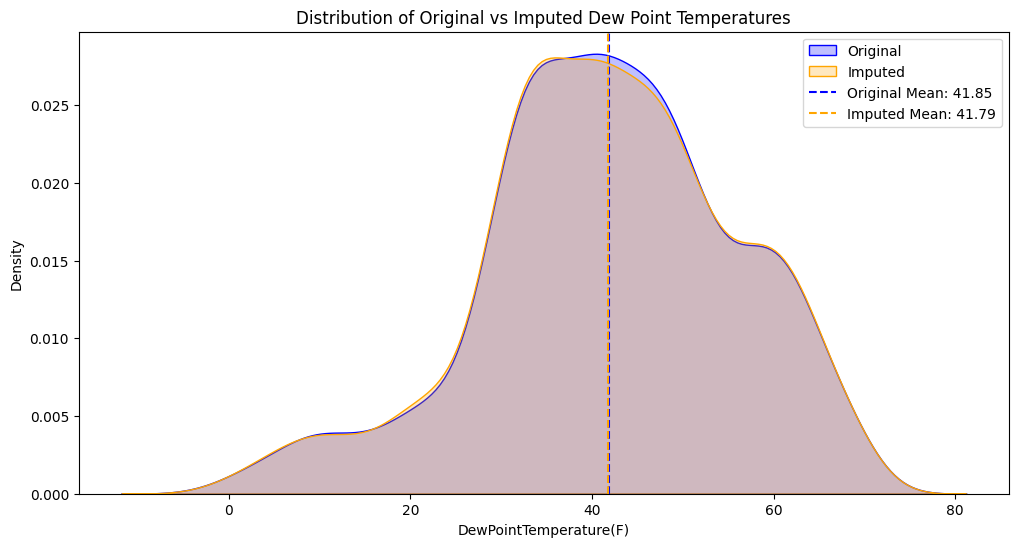

In [7]:
# Fetching the mean from the 'stats_comparison' DataFrame
original_mean = stats_comparison.loc['mean', 'Original Dew Point Temperature(F)']
imputed_mean = stats_comparison.loc['mean', 'Imputed Dew Point Temperature(F)']

# Distribution plot
plt.figure(figsize=(12, 6))
sns.kdeplot(bike['DewPointTemperature(F)'], label='Original', fill=True, color='blue')
sns.kdeplot(bike['DewPointTemperature(F)_Imputed'], label='Imputed', fill=True, color='orange')

# Add mean line for original data
plt.axvline(original_mean, color='blue', linestyle='--', label=f'Original Mean: {original_mean:.2f}')

# Add mean line for imputed data
plt.axvline(imputed_mean, color='orange', linestyle='--', label=f'Imputed Mean: {imputed_mean:.2f}')

plt.title('Distribution of Original vs Imputed Dew Point Temperatures')
plt.xlabel('DewPointTemperature(F)')
plt.ylabel('Density')
plt.legend()
plt.show()

__Imputation based on Magnus formula was successful! Here's why?__ <br/>
1. The mean (41.79) and median (41.60) of the imputed values are very close to those of the original values - Mean(41.85) and median (41.90). This indicates that the imputation method preserved the central tendency of the data, which is crucial for maintaining the integrity of the dataset.
2. The standard deviation of the imputed data (14.09) is nearly identical to that of the original (14.04), suggesting that the variability in the data has been maintained. This is important as it implies that the imputation did not artificially inflate or deflate the natural spread of the data.
3. The range, defined by the minimum (-2.20) and maximum (71.60) values, remains unchanged after imputation. This consistency ensures that the imputation process did not introduce any outliers.
4. The quartiles (25th, 50th, and 75th percentiles) of the imputed data align closely with those of the original data. This alignment shows that the distribution's shape has not been skewed by the imputation process.
5. The overlaid kernel density plots of the original and imputed Dew Point Temperatures illustrate that the imputed values closely follow the distribution of the original data. 

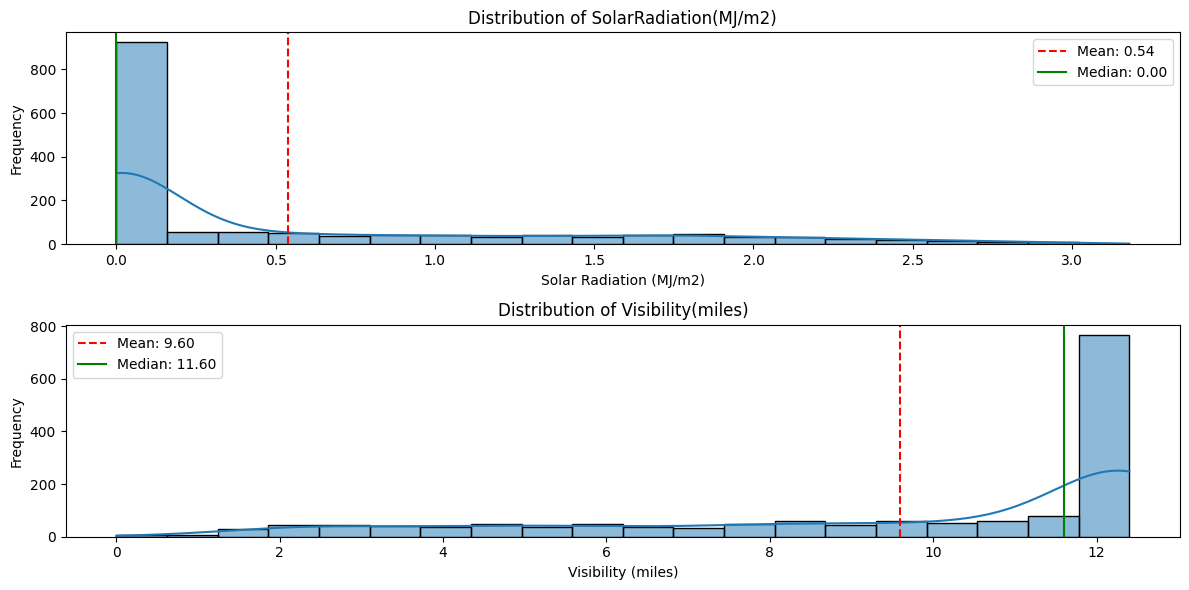

In [8]:
# Now, imputing the missing values for Solar Radiation and Visibility

# Calculate mean and median for Solar Radiation and Visibility
solar_radiation_mean = bike['SolarRadiation(MJ/m2)'].mean()
solar_radiation_median = bike['SolarRadiation(MJ/m2)'].median()
visibility_mean = bike['Visibility(miles)'].mean()
visibility_median = bike['Visibility(miles)'].median()

# Plotting the distributions 
plt.figure(figsize=(12, 6))

# Histogram for Solar Radiation
plt.subplot(2, 1, 1)
sns.histplot(bike['SolarRadiation(MJ/m2)'], bins=20, kde=True)
plt.axvline(solar_radiation_mean, color='red', linestyle='--', label=f'Mean: {solar_radiation_mean:.2f}')
plt.axvline(solar_radiation_median, color='green', linestyle='-', label=f'Median: {solar_radiation_median:.2f}')
plt.title('Distribution of SolarRadiation(MJ/m2)')
plt.xlabel('Solar Radiation (MJ/m2)')
plt.ylabel('Frequency')
plt.legend()

# Histogram for Visibility
plt.subplot(2, 1, 2)
sns.histplot(bike['Visibility(miles)'].dropna(), bins=20, kde=True)
plt.axvline(visibility_mean, color='red', linestyle='--', label=f'Mean: {visibility_mean:.2f}')
plt.axvline(visibility_median, color='green', linestyle='-', label=f'Median: {visibility_median:.2f}')
plt.title('Distribution of Visibility(miles)')
plt.xlabel('Visibility (miles)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

__Solar Radiation (MJ/m2):__
1. The distribution for Solar Radiation is highly skewed to the right, with the majority of values clustered near zero. This suggests that there are many time intervals with little to no solar radiation, which is common during night hours or when solar exposure is minimal.
2. The mean of solar radiation is approximately 0.54 MJ/m2, and the median is 0 MJ/m2, indicating a right-skewed distribution since the mean is greater than the median.
3. The tail of the distribution extends towards higher values of solar radiation but with significantly fewer occurrences. These higher values could correspond to daytime hours with peak solar radiation.

__Visibility (miles):__
1. The distribution for Visibility exhibits a left skew, with a high frequency of higher visibility values. The tail of the distribution stretches towards lower visibility values, indicating that low visibility situations are less common.
2. The mean visibility is approximately 9.6 miles, which is less than the median visibility of 11 miles, confirming the left-skewed nature of the distribution.
3. The mode of the distribution is at the maximum value of visibility, suggesting that the conditions are often clear, which is typical for most weather conditions.

In [9]:
# Extract additional time features from 'DateHour'
bike['hour'] = bike['DateHour'].dt.hour
bike['minute'] = bike['DateHour'].dt.minute
bike['second'] = bike['DateHour'].dt.second
bike['day_of_week'] = bike['DateHour'].dt.dayofweek
bike['month'] = bike['DateHour'].dt.month
bike['day_of_month'] = bike['DateHour'].dt.day

# Display the dataframe
bike[['DateHour', 'hour', 'minute','second', 'day_of_week', 'month', 'day_of_month']].head()

# Day of the week encoding: 0 - Monday, 1 -Tuesday and so on...

,DateHour,hour,minute,second,day_of_week,month,day_of_month
0,2023-10-14 05:59:55.000,5,59,55,5,10,14
1,2023-10-26 08:59:53.000,8,59,53,3,10,26
2,2023-09-23 21:59:57.000,21,59,57,5,9,23
3,2023-12-19 14:00:00.000,14,0,0,1,12,19
4,2023-10-30 12:59:52.855,12,59,52,0,10,30


In [10]:
# Imputing missing values for Solar Radiation

# Assuming nighttime hours from 21 to 5, imputing Solar Radiation as 0 for these hours. 
night_hours = list(range(21, 24)) + list(range(0, 6))
bike.loc[(bike['hour'].isin(night_hours)) & (bike['SolarRadiation(MJ/m2)'].isnull()), 'SolarRadiation(MJ/m2)'] = 0

# For other hours, using the median value of solar radiation for each hour
bike['SolarRadiation(MJ/m2)_Imputed'] = bike.groupby('hour')['SolarRadiation(MJ/m2)'].transform(lambda x: x.fillna(x.median()))

solar_radiation_Imputed_mean = bike['SolarRadiation(MJ/m2)_Imputed'].mean()
solar_radiation_Imputed_median = bike['SolarRadiation(MJ/m2)_Imputed'].median()

__Strategy__ - 
1. Recognizing that solar radiation is virtually nonexistent at night, all missing values during the nighttime hours (from 9 PM to 5 AM) are set to zero. This aligns with the understanding that there's no solar exposure during these hours.

2. The median imputation strategy for solar radiation values during daylight hours is predicated on the objective to maintain the integrity of the dataset while addressing missing values in a statistically robust manner. By imputing the median solar radiation for each hour, I'm leveraging the central tendency of the data, which inherently minimizes the impact of outliers and extreme variations that can occur due to transient weather conditions or seasonal changes.

3. This approach acknowledges the variability in solar radiation across different days but assumes that within the same hour across the dataset, the median provides a reasonable estimate that reflects a typical solar exposure level. 

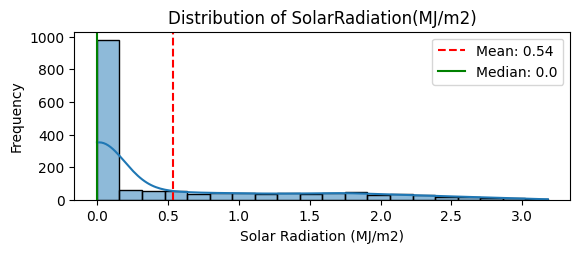

In [11]:
# Histogram for Solar Radiation
plt.subplot(2, 1, 1)
sns.histplot(bike['SolarRadiation(MJ/m2)'], bins=20, kde=True)
plt.axvline(solar_radiation_mean, color='red', linestyle='--', label=f'Mean: {solar_radiation_mean:.2f}')
plt.axvline(solar_radiation_median, color='green', linestyle='-', label=f'Median: {solar_radiation_median}')
plt.title('Distribution of SolarRadiation(MJ/m2)')
plt.xlabel('Solar Radiation (MJ/m2)')
plt.ylabel('Frequency')
plt.legend()

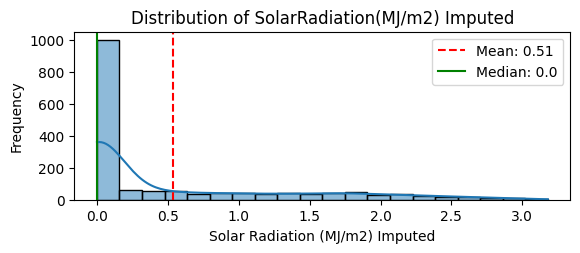

In [12]:
# Histogram for Solar Radiation Imputed
plt.subplot(2, 1, 1)
sns.histplot(bike['SolarRadiation(MJ/m2)_Imputed'], bins=20, kde=True)
plt.axvline(solar_radiation_mean, color='red', linestyle='--', label=f'Mean: {solar_radiation_Imputed_mean:.2f}')
plt.axvline(solar_radiation_median, color='green', linestyle='-', label=f'Median: {solar_radiation_Imputed_median}')
plt.title('Distribution of SolarRadiation(MJ/m2) Imputed')
plt.xlabel('Solar Radiation (MJ/m2) Imputed')
plt.ylabel('Frequency')
plt.legend()

The distributions of the original and imputed Solar Radiation show that the imputation strategy effectively preserved the overall shape and central tendency of the data:

1. Both distributions have a median of 0.0, indicating that the most common value of solar radiation has been maintained after imputation.

2. The shape of the distribution remains unchanged post-imputation, with a high frequency of low or zero values and a long right tail, reflecting the natural behavior of solar radiation.

3. The mean before and after imputation is very close (0.54 and 0.51, respectively), suggesting that the imputation has not significantly altered the average solar radiation in the dataset.

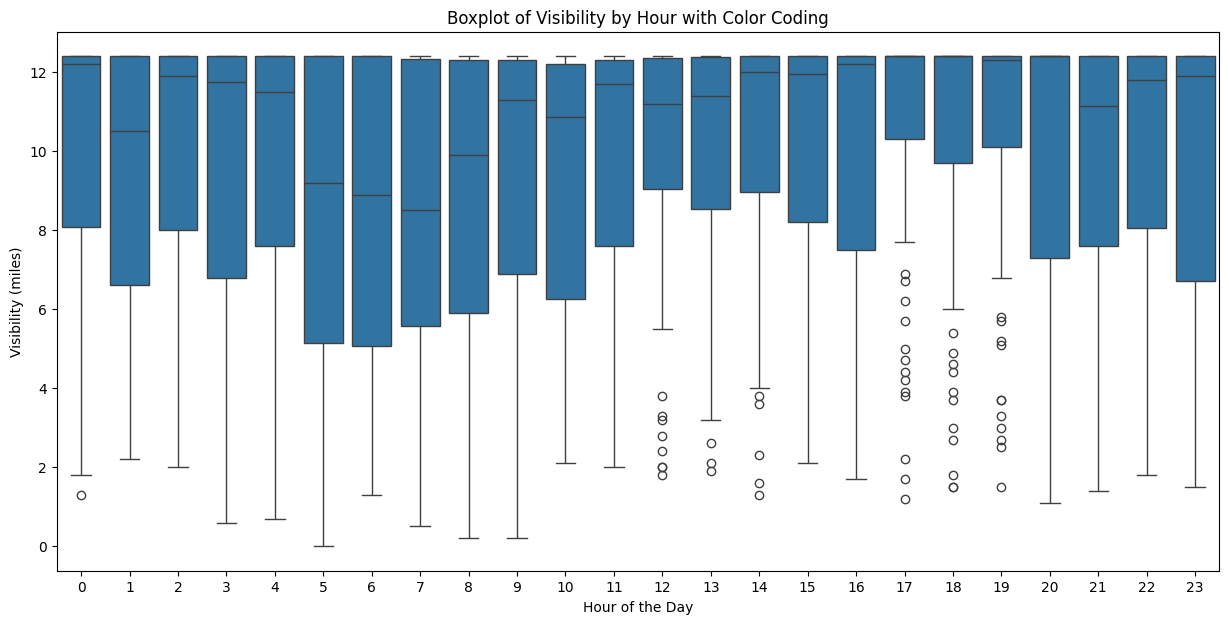

In [13]:
# Visibility Boxplot
plt.figure(figsize=(15, 7))
sns.boxplot(x='hour', y='Visibility(miles)', data=bike)
plt.title('Boxplot of Visibility by Hour with Color Coding')
plt.xlabel('Hour of the Day')
plt.ylabel('Visibility (miles)')

# Show the plot
plt.show()

The boxplot of visibility by hour provides an interesting insight into the temporal patterns of visibility throughout the day:

1. The boxplot reveals that in the early morning hours, specifically between 5 AM to 7 AM, there is a notable decrease in visibility. The lower median values during these hours, coupled with the wider box spread suggest that visibility is not only lower on average but also more variable. This could be attributed to common early morning atmospheric conditions such as fog or mist, which are often transient and can cause significant fluctuations in visibility.

2. In contrast, the evening hours from approximately 8 PM to 12 AM show a different pattern. The box and whiskers are narrower and show that visibility is not only higher on average compared to early morning but also more consistent. This could be due to the stabilization of atmospheric conditions as the temperature drops, reducing the likelihood of weather phenomena that severely impact visibility.

3. During the central hours of the day, from 8 AM to 7 PM, the boxplot illustrates a period of heightened and stable visibility. The interquartile ranges are tight, indicating that visibility is not just higher but also exhibits less fluctuation. This can be expected as the sun is at its peak, and any morning atmospheric conditions that reduce visibility have typically dissipated.

__Imputation Strategy:__
Given the clear cyclical pattern observed in the boxplot, the imputation of missing visibility values is conducted with careful consideration of the time of day. Utilizing the median visibility value for each specific hour is the approach because it captures the central tendency of the data while remaining robust against the presence of outliers. This method recognizes the distinct visibility patterns at different times and ensures that the imputation reflects the actual conditions experienced during those periods.

In [14]:
# Calculate the median visibility for each hour
median_visibility_by_hour = bike.groupby('hour')['Visibility(miles)'].transform('median')

# Impute missing values with the median visibility of their respective hour
bike['Visibility(miles)_Imputed'] = bike['Visibility(miles)'].fillna(median_visibility_by_hour)

In [15]:
# Compare descriptive statistics before and after imputation
original_stats = bike['Visibility(miles)'].describe().round(decimals = 2)
imputed_stats = bike['Visibility(miles)_Imputed'].describe().round(decimals = 2)

stats_comparison = pd.DataFrame({'Original': original_stats, 'Imputed': imputed_stats})
print(stats_comparison)

# Note:The imputation has slightly reduced the variability (standard deviation), which is also a typical outcome of replacing missing values with the median.
# As the missing data, which might have added variability, is replaced by the median values.

       Original  Imputed
count   1575.00  1638.00
mean       9.60     9.66
std        3.51     3.47
min        0.00     0.00
25%        7.30     7.50
50%       11.60    11.65
75%       12.40    12.40
max       12.40    12.40


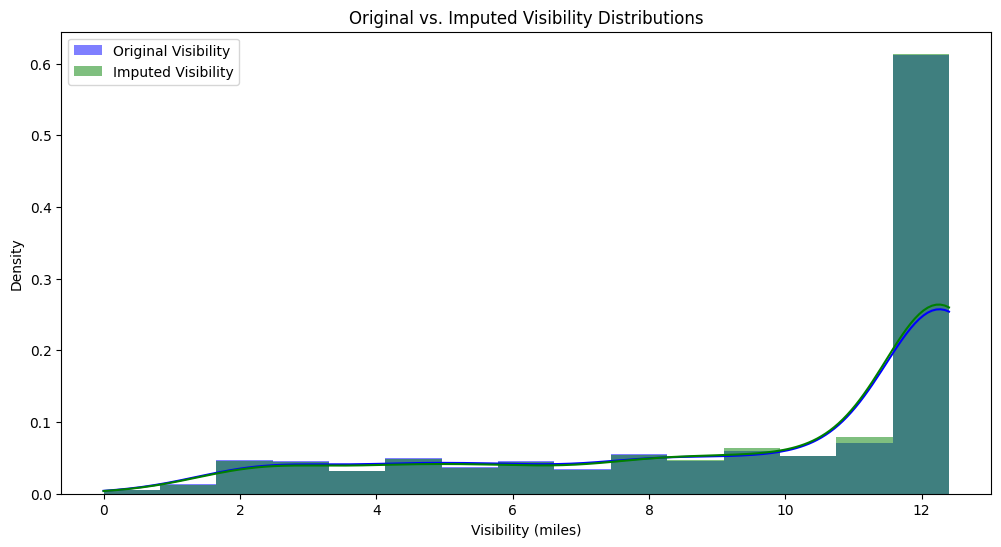

In [16]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the original visibility data
sns.histplot(bike['Visibility(miles)'], color="blue", label='Original Visibility', kde=True, stat="density", linewidth=0)

# Plot the imputed visibility data
sns.histplot(bike['Visibility(miles)_Imputed'], color="green", label='Imputed Visibility', kde=True, stat="density", linewidth=0, alpha=0.5)

# Plot legends and titles
plt.legend()
plt.title('Original vs. Imputed Visibility Distributions')
plt.xlabel('Visibility (miles)')
plt.ylabel('Density')
plt.show()

# Perfect overlap between the curve lines
# Similarly, like the Solar Radiation we can see for Visibility that our imputation was very well perfomed and there is not much difference in the values for Descriptive Statistics and also an overlay between the lines for original visibility and imputed visibility in the graph.

In [17]:
# Dropping the original DewPointTemperature, Visibility, SolarRadiation, DateHour features from the DataFrame as we no longer need it!
bike.drop(columns=['DewPointTemperature(F)'], inplace=True)
bike.drop(columns=['Visibility(miles)'], inplace=True)
bike.drop(columns=['SolarRadiation(MJ/m2)'], inplace=True)
bike.drop(columns=['DateHour'], inplace=True)

In [18]:
# Checking for missing values
print(bike.isnull().sum().sum())

# All missing values have been handled successfuly! Let's proceed with EDA and Feature Engineering now.

0


<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Exploratory Data Analysis </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [19]:
# Encode the categorical variables
bike['Holiday_Encoded'] = bike['Holiday'].map({'No': 0, 'Yes': 1})
bike['FunctioningDay_Encoded'] = bike['FunctioningDay'].map({'No': 0, 'Yes': 1})

# Drop the original Holiday, FunctioningDay categorical features from the Dataframe
bike.drop(columns=['Holiday'], inplace=True)
bike.drop(columns=['FunctioningDay'], inplace=True)

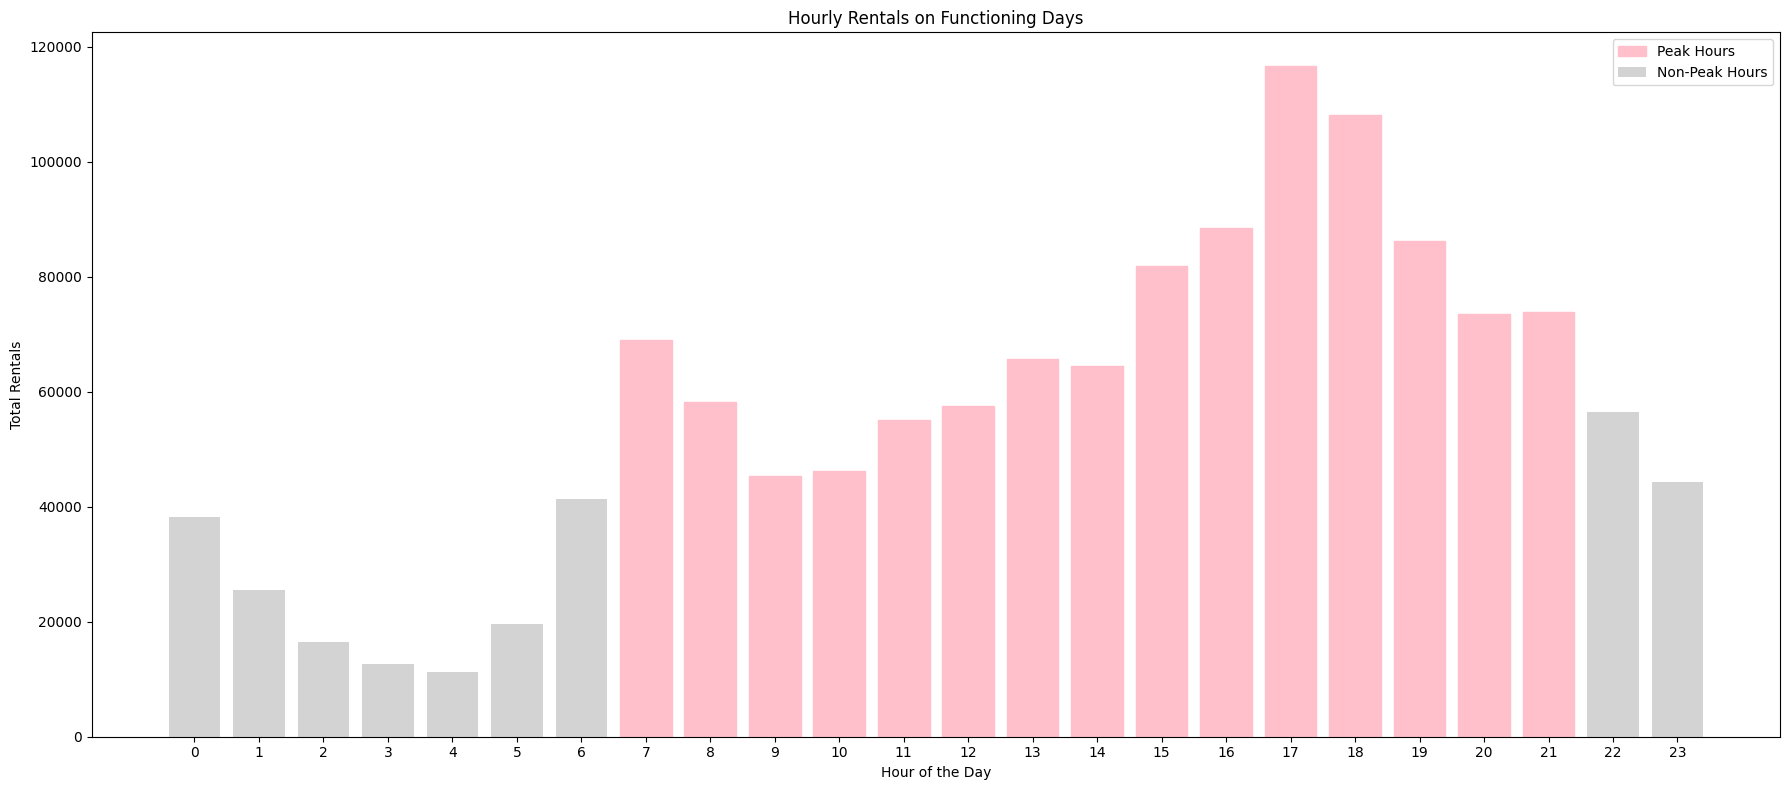

In [20]:
# Group by 'hour' and aggregate the rentals for functioning days
functioning_day_rentals = bike[bike['FunctioningDay_Encoded'] == 1]
hourly_rentals_functioning_day = functioning_day_rentals.groupby('hour')['RENTALS'].sum()

# Define peak hours
peak_hours = range(7, 22)

# Create a bar plot
plt.figure(figsize=(18, 8))
bars = plt.bar(hourly_rentals_functioning_day.index, hourly_rentals_functioning_day.values, color='lightgray', label='Non-Peak Hours')

# Highlight peak hours
for i in peak_hours:
    bars[i].set_color('pink')
    bars[i].set_label('Peak Hours')

# Avoid duplicates in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

# Plot formatting
plt.title('Hourly Rentals on Functioning Days')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Rentals')
plt.xticks(hourly_rentals_functioning_day.index)
plt.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.show()

1. The hours between 7 am and 9 pm are identified as peak times, evident from the significant height of the bars in pink. The rentals peak during midday and afternoon, and stay consistently high until the evening, suggesting a robust demand for bikes during typical commuting hours and leisure periods. This pattern aligns with the urban lifestyle in Chicago, where residents rely on bikes for both work commutes and recreational activities. 
2. The contrast between peak and non-peak hours is pronounced, with the latter showing substantially lower rental numbers. Early mornings before 6 am and late nights after 9 pm see a marked decrease in rentals. These trends could inform the redistribution schedule of bikes, ensuring higher availability during high-demand periods and efficient resource allocation during off-peak times.
3. Rentals on non-functioning days are zero, hence not displayed.



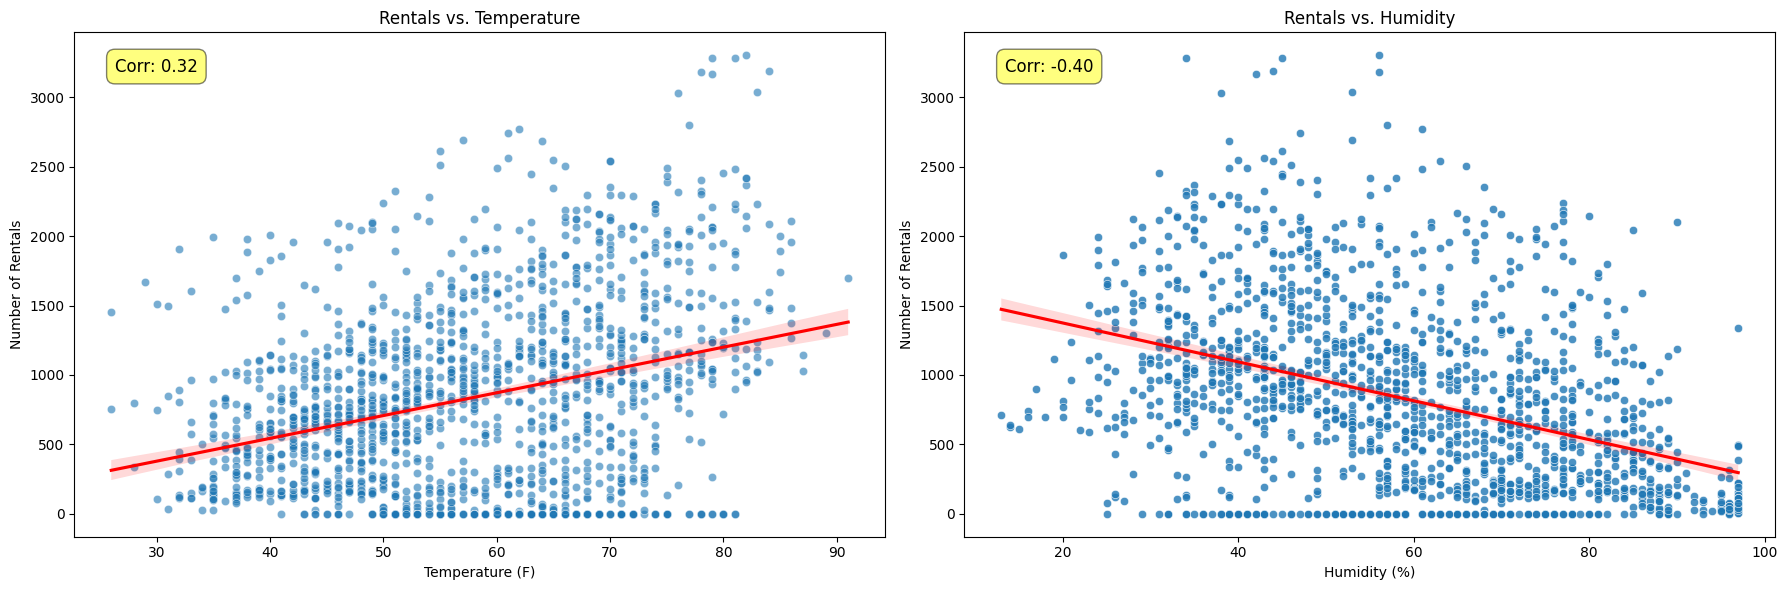

In [21]:
# Exclude 'id' column from correlation calculation
bike_no_id = bike.drop(columns=['ID'])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Temperature vs. Rentals Scatter Plot 
sns.scatterplot(ax=axes[0], data=bike_no_id, x='Temperature(F)', y='RENTALS', alpha=0.6)
sns.regplot(ax=axes[0], data=bike_no_id, x='Temperature(F)', y='RENTALS', scatter=False, color='red')
axes[0].set_title('Rentals vs. Temperature')
axes[0].set_xlabel('Temperature (F)')
axes[0].set_ylabel('Number of Rentals')

# Humidity vs. Rentals Scatter Plot 
sns.scatterplot(ax=axes[1], data=bike_no_id, x='Humidity(%)', y='RENTALS', alpha=0.8)
sns.regplot(ax=axes[1], data=bike_no_id, x='Humidity(%)', y='RENTALS', scatter=False, color='red')
axes[1].set_title('Rentals vs. Humidity')
axes[1].set_xlabel('Humidity (%)')
axes[1].set_ylabel('Number of Rentals')

# Calculate the correlation
correlation = bike_no_id.corr()

# Extract the specific correlation coefficients
rentals_temperature_corr = correlation.loc['RENTALS', 'Temperature(F)']
rentals_humidity_corr = correlation.loc['RENTALS', 'Humidity(%)']

# Annotate the correlation coefficient on the plots
axes[0].text(0.05, 0.95, f'Corr: {rentals_temperature_corr:.2f}', transform=axes[0].transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))
axes[1].text(0.05, 0.95, f'Corr: {rentals_humidity_corr:.2f}', transform=axes[1].transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.show()

1. The positive correlation of 0.32 suggests a moderate association where bike rentals tend to increase as the temperature rises. The upward trend line in the first plot supports this, showing that warmer weather could be more conducive to biking activities, possibly due to the comfort and enjoyment of outdoor activities in milder conditions. 
2. Conversely, the negative correlation of -0.40 indicates an inverse relationship between rentals and humidity; as humidity levels rise, bike rentals tend to decrease. The downward trend line in the second plot shows this negative relationship, hinting that high humidity may deter people from biking, perhaps due to discomfort associated with more humid conditions.
3. The scatterplots clearly demonstrate that weather conditions have a significant impact on bike rental patterns. This nuanced understanding of the influence of weather can be leveraged by bike rental companies to anticipate changes in demand and adjust their fleet distribution accordingly. Strategic placement of bikes during favorable weather conditions and marketing initiatives to encourage usage during less ideal weather could help mitigate the impact of these environmental factors.

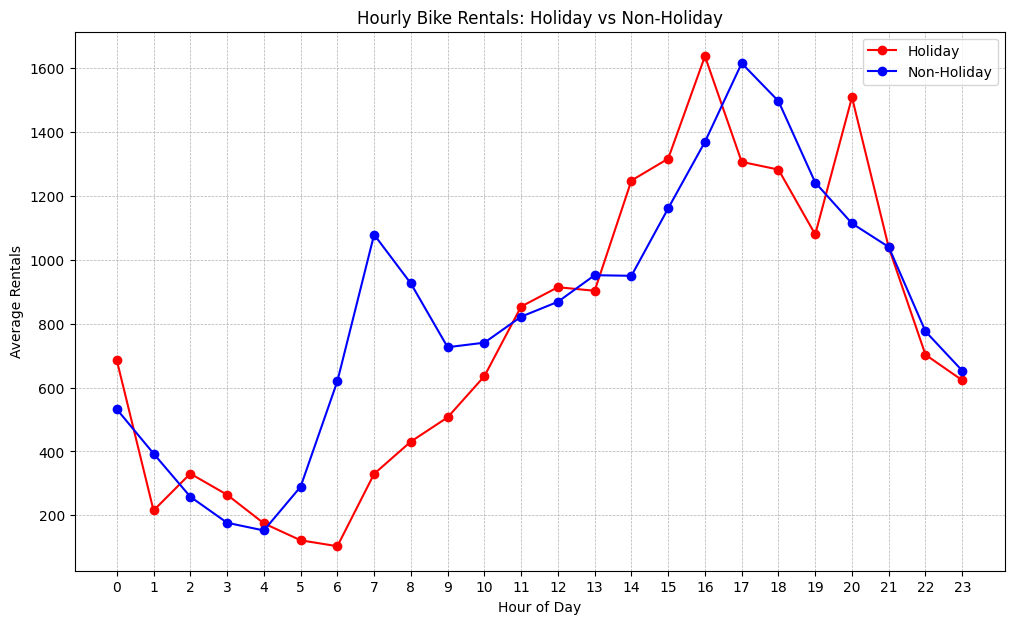

In [22]:
# Calculate mean rentals for each hour by holiday and non-holiday
hourly_rentals_holiday = bike[bike['Holiday_Encoded'] == 1].groupby('hour')['RENTALS'].mean()
hourly_rentals_non_holiday = bike[bike['Holiday_Encoded'] == 0].groupby('hour')['RENTALS'].mean()

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(hourly_rentals_holiday.index, hourly_rentals_holiday.values, label='Holiday', marker='o', color='red')
plt.plot(hourly_rentals_non_holiday.index, hourly_rentals_non_holiday.values, label='Non-Holiday', marker='o', color='blue')
plt.title('Hourly Bike Rentals: Holiday vs Non-Holiday')
plt.xlabel('Hour of Day')
plt.ylabel('Average Rentals')
plt.xticks(np.arange(24))  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

1. There's a pronounced increase in rentals from late morning to early afternoon on holidays, peaking around 4 PM. This surge likely reflects the leisurely pace of holidays, where users have the flexibility to engage in midday outings or recreational biking.

2. On non-holidays, rental activity peaks during the evening rush hours, particularly around 5 PM, a pattern consistent with commuters using bikes for their evening return journey. 

__Strategic Recommendations__: The distinct usage patterns on holidays versus non-holidays suggest an opportunity for Chicago Bike Rental Company to tailor their service offerings. On holidays, promoting leisure routes and family-friendly packages during midday could capitalize on the increased demand. Conversely, on non-holidays, focusing on commuter benefits, such as expedited rental processes during peak evening hours, could enhance user experience and retain the commuter base. Additionally, considering the drop in evening rentals on holidays, introducing special rates or incentives during these hours could help maintain a steady flow of rentals.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Transformations </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [23]:
# Taking log transformation of the target variable
bike['log_RENTALS'] = np.log1p(bike['RENTALS'])

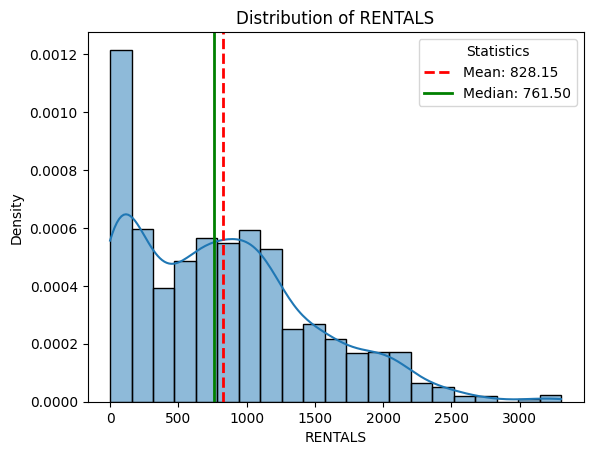

Skewness RENTALS: 0.722


In [24]:
# Plotting the distribution of 'RENTALS' 
sns.histplot(bike['RENTALS'], kde=True, stat='density')
plt.title('Distribution of RENTALS')
plt.xlabel('RENTALS')
plt.ylabel('Density')

# Calculate mean and median
mean_rentals = bike['RENTALS'].mean()
median_rentals = bike['RENTALS'].median()

# Vertical lines for mean and median
plt.axvline(mean_rentals, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rentals:.2f}')
plt.axvline(median_rentals, color='green', linestyle='-', linewidth=2, label=f'Median: {median_rentals:.2f}')

# Show legend
plt.legend(title='Statistics')

# Display the plot
plt.show()

# Checking the skewness of 'RENTALS'
skewness_rentals = bike['RENTALS'].skew().round(decimals = 3)
print("Skewness RENTALS:", skewness_rentals)

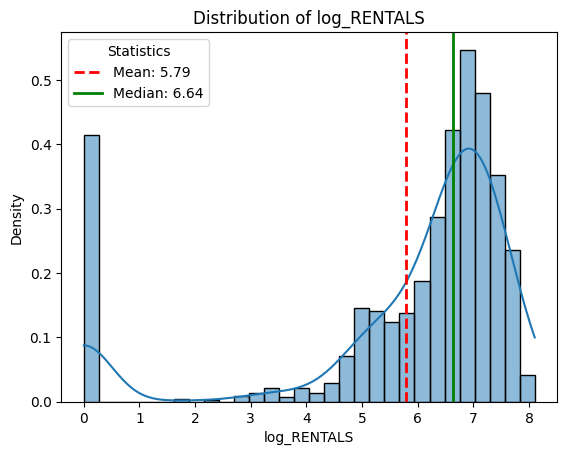

Skewness log_RENTALS: -1.83


In [25]:
# Plotting the distribution of 'log_RENTALS'
sns.histplot(bike['log_RENTALS'], kde=True, stat='density')
plt.title('Distribution of log_RENTALS')
plt.xlabel('log_RENTALS')
plt.ylabel('Density')

# Calculate mean and median for log_RENTALS
mean_log_rentals = bike['log_RENTALS'].mean()
median_log_rentals = bike['log_RENTALS'].median()

# Add vertical lines for mean and median
plt.axvline(mean_log_rentals, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_log_rentals:.2f}')
plt.axvline(median_log_rentals, color='green', linestyle='-', linewidth=2, label=f'Median: {median_log_rentals:.2f}')

# Show legend
plt.legend(title='Statistics')

# Display the plot
plt.show()

# Checking the skewness of 'log_RENTALS'
skewness_log_rentals = bike['log_RENTALS'].skew().round(decimals = 3)
print("Skewness log_RENTALS:", skewness_log_rentals)

__Original Distribution of RENTALS:__
The initial distribution of bike rentals is right-skewed, suggesting that while most of the time, the bike rentals per interval are on the lower end (as indicated by the median of 761.50), there are occasional periods with significantly higher rentals. This skewness is driven by outliers, as evident from the mean (828.15) being greater than the median, implying that a relatively small number of very busy periods are pushing the average rentals higher.

__Transformed Distribution of log_RENTALS:__
After applying the logarithmic transformation, the distribution becomes left-skewed. This indicates that when we consider the multiplicative effects on bike rentals (since the log transformation interprets changes multiplicatively), there are more instances of higher rental counts than one would expect from a normal distribution. The skewness is now negative, and the mean (5.79) is less than the median (6.64), suggesting that while most periods have moderate to high rentals, there are more intervals with fewer rentals than the log-scale median would suggest.

__Key Insight:__
The log transformation has effectively addressed the issue of outliers by dampening the influence of extreme values, as seen by the mean being closer to the bulk of the data. This results in a distribution that better represents the central tendency of the bike rental data, which is crucial for predictive modeling. It reduces the variance in rental counts, thus providing a more stable and reliable basis for predicting demand. Also, our models trained on log-transformed data are less sensitive to extreme fluctuations in rentals, enabling more consistent and accurate forecasts. However, the presence of left skewness post-transformation indicates that the model might need to be adjusted to counteract the slight bias toward predicting fewer rentals than actually occur.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Feature Engineering </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [26]:
# Feature 1: Part of Day
# Convert 'hour' into categorical time-of-day bins
def categorize_hour(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 16:
        return 'afternoon'
    elif 16 <= hour <= 20:
        return 'evening'
    else:
        return 'night'

bike['part_of_day'] = bike['hour'].apply(categorize_hour)

# One-hot encode the 'part_of_day' columns
bike = pd.get_dummies(bike, columns=['part_of_day'], drop_first=True)

1. The 'Part of Day' feature translates the 'hour' of rentals into meaningful segments reflecting daily human activities, recognizing that bike rental patterns are not uniform throughout the day but instead fluctuate with common daily routines. By categorizing hours into 'morning', 'afternoon', 'evening', and 'night', we specifically capture the spikes in rental demand during typical commute times and the expected lulls during off-peak hours.

2. One-hot encoding these categories rather than using the hour as a continuous variable allows the model to capture the non-linear nature of time without unnecessarily complicating the model with every individual hour. Utilizing 'drop_first' in one-hot encoding ensures that the model is not burdened with redundant information, which could lead to multicollinearity and overfitting.

3. By inferring 'afternoon' from the absence of other time categories, I'm maintaining model simplicity. If 'morning', 'evening', and 'night' are all false, it implies the 'afternoon' category, providing a complete cycle of the day without explicit specification. This feature aids in understanding when to allocate more bikes and resources, matching the natural ebb and flow of urban life, and allowing for targeted strategies during peak rental times.

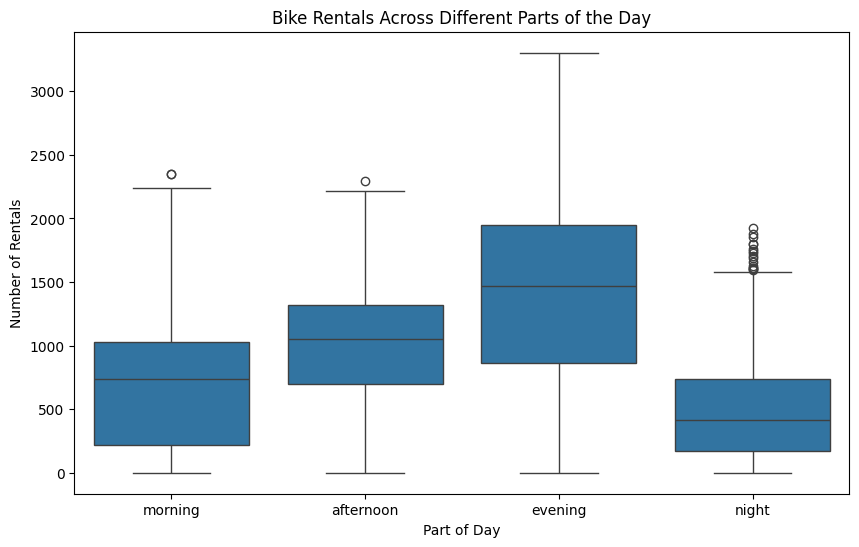

In [27]:
# Creating 'part_of_day' column for visualization
bike['part_of_day'] = bike['hour'].apply(categorize_hour)

# Rentals across different parts of the day
plt.figure(figsize=(10, 6))
sns.boxplot(data=bike, x='part_of_day', y='RENTALS', order=['morning', 'afternoon', 'evening', 'night'])
plt.title('Bike Rentals Across Different Parts of the Day')
plt.xlabel('Part of Day')
plt.ylabel('Number of Rentals')
plt.show()

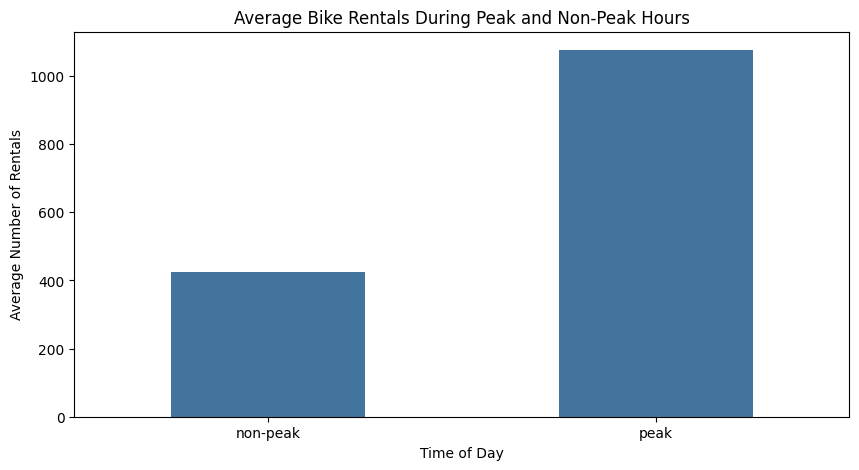

In [28]:
# Classify each rental into 'peak' and 'non-peak' based on the 'hour' column
bike['time_of_day'] = bike['hour'].apply(lambda x: 'peak' if 7 <= x <= 21 else 'non-peak')

# Group by the new 'time_of_day' column 
average_rentals = bike.groupby('time_of_day')['RENTALS'].mean().reindex(['non-peak', 'peak'])

# Plot the results with the specified color
plt.figure(figsize=(10, 5))
average_rentals.plot(kind='bar', color='#43749d')  
plt.title('Average Bike Rentals During Peak and Non-Peak Hours')
plt.ylabel('Average Number of Rentals')
plt.xlabel('Time of Day')
plt.xticks(rotation=0)  
plt.show()

1. The boxplot illustrates the distribution of rentals throughout different parts of the day, with the evening showing higher variability and median rentals compared to morning, afternoon and night. This suggests that evenings might not only have higher demand but also more fluctuation, possibly due to leisure activities or varying end times for work and school.
2. The bar graph between peak and non-peak hours shows a distinct spike in average bike rentals during peak hours (7 AM to 9 PM), underscoring the need to concentrate bike-sharing resources during these busy times to support the city's commuting patterns.
3. The evening peak in the boxplot, combined with the overall higher average rentals during peak hours shown in the bar graph, indicates that bike-sharing services are most utilized when people are concluding their workday. This consistent pattern suggests a strategic opportunity for allocating additional bikes in the evening to accommodate both the routine commute and the variable leisure activities that contribute to rental fluctuations.


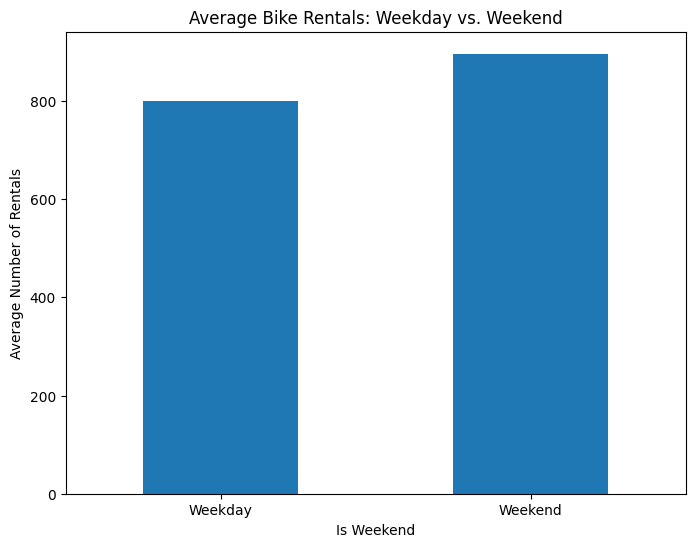

Percent increase in Avg. rentals from weekday to weekend: 11.94


In [53]:
# Feature 2: Is it weekend or not?
# Encode 'day_of_week' as binary features for weekdays and weekends
bike['is_weekend'] = bike['day_of_week'].apply(lambda x: 1 if x >= 5 else 0) # 5 - Saturday, 6 - Sunday

# Calculate average rentals for weekdays and weekends
average_rentals_weekday_weekend = bike.groupby('is_weekend')['RENTALS'].mean()

# Plotting the average rentals by weekday/weekend
plt.figure(figsize=(8, 6))
average_rentals_weekday_weekend.plot(kind='bar')
plt.title('Average Bike Rentals: Weekday vs. Weekend')
plt.xlabel('Is Weekend')
plt.ylabel('Average Number of Rentals')
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], rotation=0)
plt.show()

# Calculate the percent increase from weekday to weekend
percent_increase = (((average_rentals_weekday_weekend[1] - average_rentals_weekday_weekend[0]) / average_rentals_weekday_weekend[0]) * 100).round(decimals = 2)
print("Percent increase in Avg. rentals from weekday to weekend:",percent_increase)

1. This binary feature differentiates between weekdays and weekends by encoding days of the week as '0' for weekdays (Monday to Friday) and '1' for weekends, reflecting typical workweek structures and leisure patterns. The rationale behind creating 'is_weekend' stems from the distinct behaviors observed between these two timeframes. Weekends often show higher rental patterns due to more leisure time and social activities and in our case it showcases an increase of approximately 12% from the weekdays. 

2. The analysis revealed that average rentals on weekends exceed those on weekdays, suggesting that people may engage more in recreational biking or leisure trips during weekends. 

3. Including 'is_weekend' as a feature in our models allows for capturing the weekly cyclicality in bike rental data, which could be obscured when considering daily data in isolation. The company can use this feature to target weekend-specific promotions, such as family packages or event-based rental offers, to capitalize on the propensity for higher weekend rentals.

In [54]:
# Feature 3
# Create the 'Precipitation' feature
bike['Precipitation'] = ((bike['Rainfall(in)'] > 0) | (bike['Snowfall(in)'] > 0)).astype(int)

# Calculate the correlation between 'Precipitation' and 'RENTALS'
precipitation_rentals_corr = bike[['Precipitation', 'RENTALS']].corr().iloc[0, 1].round(2)
print("Correlation with Rentals:",precipitation_rentals_corr)

KeyError: 'Rainfall(in)'

1. This binary feature captures whether there was any precipitation, including rain or snow, at the time of bike rental. It's created by checking if either 'Rainfall(in)' or 'Snowfall(in)' has a value greater than zero, which indicates that some form of precipitation occurred. The decision to engineer this feature is rooted in the assumption that weather conditions, particularly precipitation, have a significant impact on the propensity to rent bikes. Rain or snow can deter people from outdoor activities due to discomfort or safety concerns.

2. While raw rainfall and snowfall data are continuous variables, the creation of a binary 'Precipitation' feature simplifies the model by reducing two variables into one, which directly impacts the rental decision. From an operational perspective, understanding how precipitation influences rental patterns enables the bike-sharing system to adapt its fleet management and maintenance scheduling accordingly.

3. Including 'Precipitation' as a feature in predictive models allows the model to account for the significant drop in demand that typically accompanies bad weather, thereby improving forecast accuracy. This is backed with the negative correlation value of -0.22 with Rentals, which indicate that as Precipitation increases, the no. of Rentals tend to decrease. 

In [31]:
# Feature 4
# adding a peak time feature 
bike['peak_time'] = bike['hour'].apply(lambda x: 1 if 7 <= x <= 21 else 0)

1. The 'peak_time' feature is engineered to identify the high-demand hours for bike rentals, typically from 7 AM to 9 PM. This binary feature is set to '1' during these hours and '0' otherwise, aligning with common workday patterns and recognizing that the demand for bikes is not constant throughout the day. By differentiating between peak and non-peak hours, we enable the model to better predict demand spikes, which are crucial for resource allocation, such as redistributing bikes to high-traffic areas during peak hours.

2. This feature informs operational decisions, such as staffing levels at rental stations, maintenance scheduling, and charging of electric bikes, ensuring that the fleet is service-ready when most needed. Accurately predicting and meeting peak demand times directly correlates with customer satisfaction, as customers experience fewer wait times and better service availability.

3. Also, 'Peak_time' can be used to implement dynamic pricing strategies where prices are adjusted based on demand, potentially increasing revenue during high-demand periods.

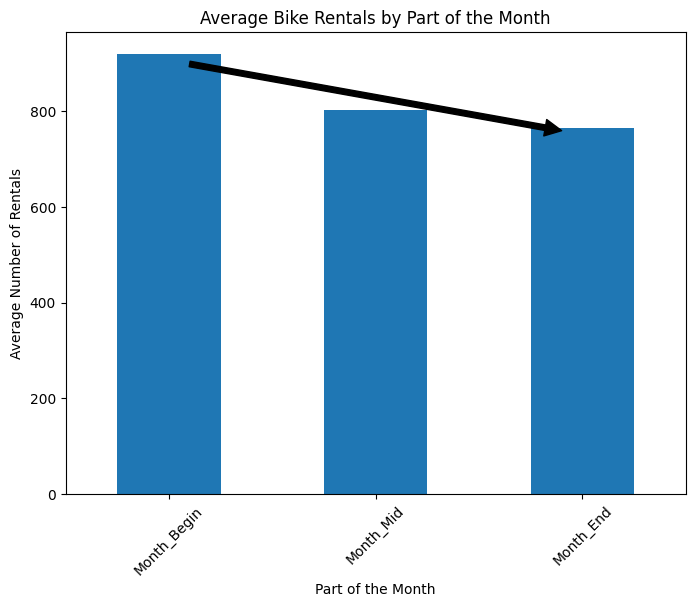

In [32]:
# Feature 5
# Define the conditions for each part of the month
conditions = [
    (bike['day_of_month'] <= 10),  # Beginning of the month
    (bike['day_of_month'] > 10) & (bike['day_of_month'] <= 20),  # Middle of the month
    (bike['day_of_month'] <= 31)  # End of the month
]

# Define the corresponding labels for the conditions
labels = ['Month_Begin', 'Month_Mid', 'Month_End']

# Use np.select to create a new column in the dataframe with the labels
bike['Month_Part'] = np.select(conditions, labels)

# Convert the 'Month_Part' column to dummy variables
month_part_dummies = pd.get_dummies(bike['Month_Part'])

# Concatenate the new dummy variables to the original dataframe
bike = pd.concat([bike, month_part_dummies], axis=1)

# Group by the new 'Month_Part' column and calculate the average rentals
average_rentals_by_month_part = bike.groupby('Month_Part')['RENTALS'].mean().reindex(['Month_Begin', 'Month_Mid', 'Month_End'])

# Plotting the average rentals by part of the month
plt.figure(figsize=(8, 6))
average_rentals_by_month_part.plot(kind='bar')
plt.title('Average Bike Rentals by Part of the Month')
plt.xlabel('Part of the Month')
plt.ylabel('Average Number of Rentals')
plt.xticks(rotation=45)

# Calculate the trend line
z = np.polyfit(range(len(labels)), average_rentals_by_month_part, 1)
p = np.poly1d(z)

# Plot the trend line
plt.plot(average_rentals_by_month_part.index, p(range(len(labels))))

# Add an arrow to the plot
plt.annotate('', xy=(2, p(2)), xytext=(0, p(0)),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

1. The 'Month_Part' feature segments the month into three distinct periods: beginning, middle, and end. This categorization is predicated on the hypothesis that consumer behavior and rental patterns may vary throughout the month due to factors such as payday cycles, monthly planning, and shifting weather conditions as the month progresses.

2. The creation of this feature is inspired by the insight that certain times of the month, like just after payday, could see an increase in discretionary spending and leisure activities, which may include increased bike rentals. The feature thus attempts to capture potential fluctuations in rental volume associated with these periods. With the 'Month_Part' feature, the bike rental company can craft targeted marketing campaigns to incentivize rentals during typically slower periods, such as offering discounts or promotions at the month's mid or end.

3. This feature aids in anticipating and managing inventory needs. For example, if data shows a dip in rentals at the month's end, the company can plan maintenance activities during this time to minimize service disruption. By encoding temporal nuances within the month, the 'Month_Part' feature adds a layer of temporal detail that can enhance the predictive accuracy of models, allowing for more nuanced forecasts than those based solely on broader timeframes like seasons or months.

In [33]:
# Renaming features to remove brackets and simplify names
bike = bike.rename(columns={
    'Temperature(F)': 'Temperature',
    'SolarRadiation(MJ/m2)_Imputed': 'SolarRadiation_Imputed',
    'Wind speed (mph)': 'Wind_speed',
    'Rainfall(in)': 'Rainfall',
    'Snowfall(in)': 'Snowfall',
    'Humidity(%)' : 'Humidity',
    'DewPointTemperature(F)_Imputed': 'DewPointTemperature_Imputed',
})

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Base Modeling </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

__Modelling__

In [34]:
# Base Modeling was done with RENTALS as the target variable as well. However, higher R-square value was being
# generated with keeping log_RENTALS as the target variable. So, went ahead with it in Base Modeling and the
# candidate models. 

import statsmodels.formula.api as smf

# Constructing the model formula for log_RENTALS
model_formula = """log_RENTALS ~ FunctioningDay_Encoded + Temperature + Humidity
                    + hour  + peak_time + Month_End + is_weekend + part_of_day_evening + Precipitation
                     + SolarRadiation_Imputed + Holiday_Encoded
                   """

# Fitting the model for log_RENTALS
lm_refined_bike_log = smf.ols(formula=model_formula, data=bike).fit()

# Displaying the model summary for log_RENTALS
print(lm_refined_bike_log.summary())

                            OLS Regression Results                            
Dep. Variable:            log_RENTALS   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     1931.
Date:                Thu, 22 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:06:58   Log-Likelihood:                -1480.2
No. Observations:                1638   AIC:                             2984.
Df Residuals:                    1626   BIC:                             3049.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Candidate Model Development </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [38]:
# Preparing x-data based on the base model
# Extracting the part of the formula after '~' in the base model

feature_part = model_formula.split('~')[1]
x_features = [feature.strip() for feature in feature_part.split('+')]
print(x_features)

['FunctioningDay_Encoded', 'Temperature', 'Humidity', 'hour', 'peak_time', 'Month_End', 'is_weekend', 'part_of_day_evening', 'Precipitation', 'SolarRadiation_Imputed', 'Holiday_Encoded']


In [36]:
# Defining the x-features and the train-test split
from sklearn.model_selection import train_test_split
                                                                            
# Creating a new DataFrame with the selected features for modeling
x_data = bike[x_features]  

# Preparing y-data 
y_data = bike['log_RENTALS']

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.25,
                                                    random_state=219)

In [37]:
# Checking the no. of observations and features in the training and test data
print(x_train.shape)
print(x_test.shape)

(1228, 11)
(410, 11)


In [39]:
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Global dictionary to store y_test_pred
model_predictions = {}

def model_evaluation(model_type, x_train, y_train, x_test, y_test, tuned_params=None, **kwargs):
    """
    Fits, predicts, and evaluates a model based on the model type and hyperparameters provided.
    
    Parameters:
    - model_type: str, type of the model ("LinearRegression", "Lasso", "Ridge", "ElasticNet", "KNeighbors", "DecisionTree")
    - x_train, y_train: Training data and labels.
    - x_test, y_test: Testing data and labels.
    - tuned_params: dict, parameters of the model that have been tuned using a technique like GridSearchCV. Default is None.
    - **kwargs: Optional keyword arguments for model hyperparameters.
    
    Returns:
    - Prints the training score, testing score, and train-test gap.
    """
    
    # Instantiate the model based on the model_type
    if model_type == "LinearRegression":
        model = LinearRegression(**kwargs)
        
    elif model_type == "Lasso":
        model = Lasso(**tuned_params) if tuned_params else Lasso()
        
    elif model_type == "Ridge":
         model = Ridge(**tuned_params) if tuned_params else Ridge()
        
    elif model_type == "SGDRegressor":
        # Specify the elastic net penalty
        penalty = kwargs.get('penalty', 'elasticnet')
        model = SGDRegressor(**tuned_params) if tuned_params else SGDRegressor(**kwargs)
  
    elif model_type == "KNeighbors":
        # Scale data for KNeighbors
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)
        
        # Finding the optimal number of neighbors
        optimal_neighbors = kwargs.get('n_neighbors', 1)  # Default to 1 
        
        # Initialize highest_score to negative infinity to ensure any score will be higher
        highest_score = -np.inf
        search_range = kwargs.get('search_range', range(1, 51)) 
        
        for n_neighbors in search_range:
            knn = KNeighborsRegressor(n_neighbors=n_neighbors)
            # Perform cross-validation and calculate the average R-squared score
            scores = cross_val_score(knn, x_train_scaled, y_train, cv=5, scoring='r2')
            average_score = np.mean(scores)
            
            if average_score > highest_score:
                highest_score = average_score
                optimal_neighbors = n_neighbors

        print(f"Optimal number of neighbors: {optimal_neighbors}")
        model = KNeighborsRegressor(n_neighbors=optimal_neighbors)
        
    elif model_type == "DecisionTree":
        model = DecisionTreeRegressor(**tuned_params) if tuned_params else DecisionTreeRegressor()
        
    else:
        raise ValueError("Invalid model type provided.")
    
    # Fit the model
    model.fit(x_train, y_train)
    
    # Predict on training and test data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Calculate R-squared scores
    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)
    
    # Calculate the gap
    gap = abs(train_score - test_score)
    
    # Calculate RMSE for both training and testing sets
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Store predictions in the global dictionary
    model_predictions[model_type] = y_test_pred
    
    # Structuring the results in a dictionary
    results = {
        "Model Name": model_type,
        "Training Score": train_score.round(4),
        "Testing Score": test_score.round(4),
        "Train-Test Gap": gap.round(4),
        "Training RMSE": train_rmse.round(4),
        "Testing RMSE": test_rmse.round(4)
    }  
    
    return results

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Hyperparameter Tuning </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [40]:
def tune_hyperparameters(model_type, x_train, y_train, **kwargs):
    """
    Tune hyperparameters for the given model type using GridSearchCV.
    
    Parameters:
    - model_type: str, type of the model ("Ridge", "Lasso", "DecisionTree")
    - x_train, y_train: Training data and labels.
    - kwargs: Additional keyword arguments for GridSearchCV.
    
    Returns:
    - A dictionary with the best parameters and the best score.
    """
    
    if model_type == "Ridge":
        model = Ridge()
        param_grid = {'alpha': np.logspace(-4, 4, 50)}
        
    elif model_type == "Lasso":
        model = Lasso()
        param_grid = {'alpha': np.logspace(-4, 4, 50)}
        
    elif model_type == "DecisionTree":
        model = DecisionTreeRegressor()
        param_grid = {
            'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        
    else:
        raise ValueError("Unsupported model type provided.")
    
    grid_search = GridSearchCV(model, param_grid, **kwargs)
    grid_search.fit(x_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_
    }


In [41]:
# Tune hyperparameters for the best 3 models. 
# Note: Linear Regression was in the best 3 models, however there are no hyperparameters available to be tuned in this model. 
# So, I went with Lasso and tuned hyperparameters for it. 

ridge_best_params = tune_hyperparameters('Ridge', x_train, y_train, cv=5, scoring='r2')
lasso_best_params = tune_hyperparameters('Lasso', x_train, y_train, cv=5, scoring='r2')
decision_tree_best_params = tune_hyperparameters('DecisionTree', x_train, y_train, cv=5, scoring='r2')

# Example printout of best parameters
print("Ridge Best Params:", ridge_best_params['best_params'])
print("Lasso Best Params:", lasso_best_params['best_params'])
print("Decision Tree Best Params:", decision_tree_best_params['best_params'])

Ridge Best Params: {'alpha': 0.08685113737513521}
Lasso Best Params: {'alpha': 0.0009540954763499944}
Decision Tree Best Params: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}


In [42]:
# Linear Regression
linear_regression_results = model_evaluation('LinearRegression', x_train, y_train, x_test, y_test)
linear_regression_results

{'Model Name': 'LinearRegression',
 'Training Score': 0.9286,
 'Testing Score': 0.9283,
 'Train-Test Gap': 0.0003,
 'Training RMSE': 0.5961,
 'Testing RMSE': 0.6069}

In [43]:
# Lasso - Hyperparamters Tuned 
lasso_results = model_evaluation('Lasso', x_train, y_train, x_test, y_test, tuned_params=lasso_best_params['best_params'])
lasso_results

{'Model Name': 'Lasso',
 'Training Score': 0.9286,
 'Testing Score': 0.9281,
 'Train-Test Gap': 0.0005,
 'Training RMSE': 0.5961,
 'Testing RMSE': 0.6078}

In [44]:
# Ridge - Hyperparamters Tuned
ridge_results = model_evaluation('Ridge', x_train, y_train, x_test, y_test, tuned_params=ridge_best_params['best_params'])
ridge_results

{'Model Name': 'Ridge',
 'Training Score': 0.9286,
 'Testing Score': 0.9282,
 'Train-Test Gap': 0.0004,
 'Training RMSE': 0.5961,
 'Testing RMSE': 0.6071}

In [45]:
# Elastic Net Regression
sgd_results = model_evaluation('SGDRegressor', x_train, y_train, x_test, y_test)
sgd_results

{'Model Name': 'SGDRegressor',
 'Training Score': -6.327955564344658e+23,
 'Testing Score': -6.39772489920299e+23,
 'Train-Test Gap': 6.976933485833204e+21,
 'Training RMSE': 1774955601043.3027,
 'Testing RMSE': 1812684887941.7195}

In [46]:
# KNN
knn_results = model_evaluation('KNeighbors', x_train, y_train, x_test, y_test)
knn_results

Optimal number of neighbors: 2


{'Model Name': 'KNeighbors',
 'Training Score': 0.7198,
 'Testing Score': -0.097,
 'Train-Test Gap': 0.8167,
 'Training RMSE': 1.1812,
 'Testing RMSE': 2.3736}

In [47]:
# Decision Tree Regression - Hyperparameters Tuned
decision_tree_results = model_evaluation('DecisionTree', x_train, y_train, x_test, y_test, tuned_params=decision_tree_best_params['best_params'])
decision_tree_results

{'Model Name': 'DecisionTree',
 'Training Score': 0.972,
 'Testing Score': 0.9633,
 'Train-Test Gap': 0.0088,
 'Training RMSE': 0.3733,
 'Testing RMSE': 0.4344}

In [48]:
# List to hold all the results
# Not displaying the SGD results as the values are extreme compared to other models

all_results = [linear_regression_results, ridge_results, lasso_results, decision_tree_results, knn_results]
results_df = pd.DataFrame(all_results)

pd.options.display.float_format = '{:,.4f}'.format
results_df

,Model Name,Training Score,Testing Score,Train-Test Gap,Training RMSE,Testing RMSE
0,LinearRegression,0.9286,0.9283,0.0003,0.5961,0.6069
1,Ridge,0.9286,0.9282,0.0004,0.5961,0.6071
2,Lasso,0.9286,0.9281,0.0005,0.5961,0.6078
3,DecisionTree,0.9720,0.9633,0.0088,0.3733,0.4344
4,KNeighbors,0.7198,-0.0970,0.8167,1.1812,2.3736


__Final Model Selection__ <br/>
The selection of the Decision Tree as the final model for the Kaggle submission is strategically aligned with its unparalleled ability to balance Accuracy with Interpretability. Exhibiting a Training Score of 0.9720 and a Testing Score of 0.9633, the Decision Tree not only surpassed its counterparts in predictive power but also demonstrated a remarkably low Train-Test Gap of 0.0088, underscoring its robustness against Overfitting. Its proficiency in partitioning the data space into smaller, manageable sub-spaces allows it to adeptly capture the intricate non-linear relationships present in our dataset, a task where linear models might falter.

Furthermore, Decision Trees stand out for their straightforward interpretability and the ease with which they can be visualized and understood, even by those with minimal statistical background.The inherent flexibility of Decision Trees to handle qualitative features and their independence from feature scaling ensures a tailored approach to exploring the dataset's unique characteristics.

In [49]:
# Performing residual analysis for the Decision Tree model
y_test_pred = model_predictions['DecisionTree']
residuals = np.expm1(y_test) - np.expm1(y_test_pred)

# Creating a dataframe for residuals
resid_df = pd.DataFrame({
    'Actual': np.expm1(y_test),
    'Predicted': np.expm1(y_test_pred),
    'Residuals': residuals
})
resid_df.head()

,Actual,Predicted,Residuals
766,314.0000,417.0287,-103.0287
241,689.0000,843.5137,-154.5137
341,18.0000,26.0631,-8.0631
1366,458.0000,411.4178,46.5822
1061,522.0000,546.2616,-24.2616


Residuals represent the discrepancy between the actual observed values and the predictions made by a model. They're essential for diagnosing a model's accuracy, indicating whether the model tends to overestimate or underestimate the observed data. A positive residual suggests the model's prediction was lower than the actual value, while a negative residual indicates an overestimation. For instance, in the above table, the actual value of 522 RENTALS with a predicted value of 546.26 RENTALS results in a residual of -24.26, demonstrating an overestimation by the model.

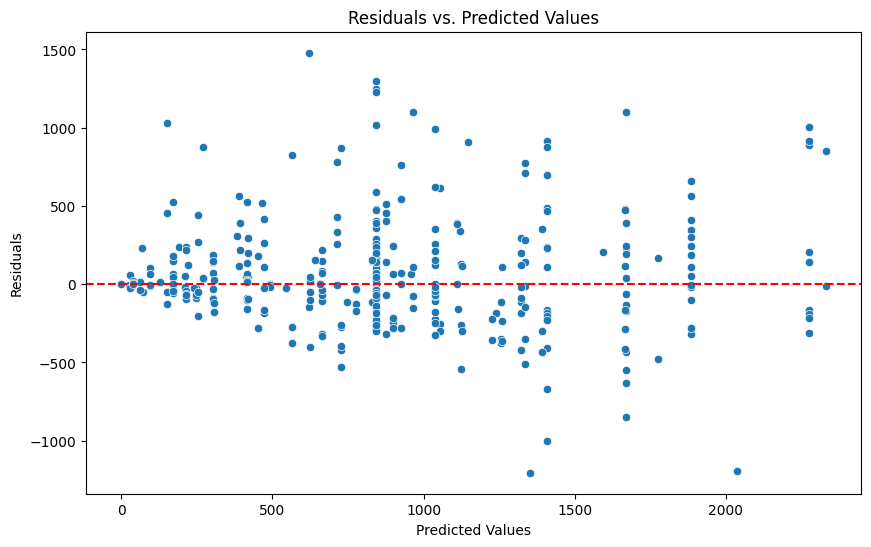

In [50]:
# Plotting the residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Predicted', y='Residuals', data=resid_df)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

__Residual Plot Analysis -__

1. The residuals are scattered between approximately -1000 and 1500, with most concentrated between -500 and 500. This spread suggests that while the model generally predicts within a reasonable range of the actual values, there are instances where the prediction error is quite significant.
2. Most of the data points are clustered around the center of the plot (near the zero line of residuals), especially for predicted values up to around 1000. This implies that the model's performance is relatively consistent for most of the early to mid-range predictions. For predicted values beyond 1000, the data points become sparser, indicating less certainty in the model's predictions for higher values.
3. Several points lie significantly above or below the zero-residual line. These may indicate outliers in the actual data or areas where the model's predictions are systematically off. 
4. There doesn't seem to be a systematic drift in one direction or another as we move across the range of predicted values, which suggests there is no inherent bias in the model predictions. The symmetry around the zero line also implies that the model does not consistently overpredict or underpredict across the data range.

In essence, this residual plot indicates that while the Decision Tree model is quite robust in handling different values, its accuracy diminishes at the higher end of predictions, and it might be influenced by potential outliers or extreme values.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> Feature Importance </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [51]:
def plot_decision_tree_feature_importances(x_train, y_train, tuned_params):
    
    # Train the Decision Tree model
    dt_model = DecisionTreeRegressor(**tuned_params)
    dt_model.fit(x_train, y_train)

    # Get feature importances
    importances = dt_model.feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # Get feature names from the x_train DataFrame
    feature_names = list(x_train.columns)
    
    # Rearrange feature names so they match the sorted feature importances
    sorted_feature_names = [feature_names[i] for i in indices]

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), sorted_feature_names)
    plt.gca().invert_yaxis()  # To have the highest value on top
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance in Decision Tree')
    plt.show()

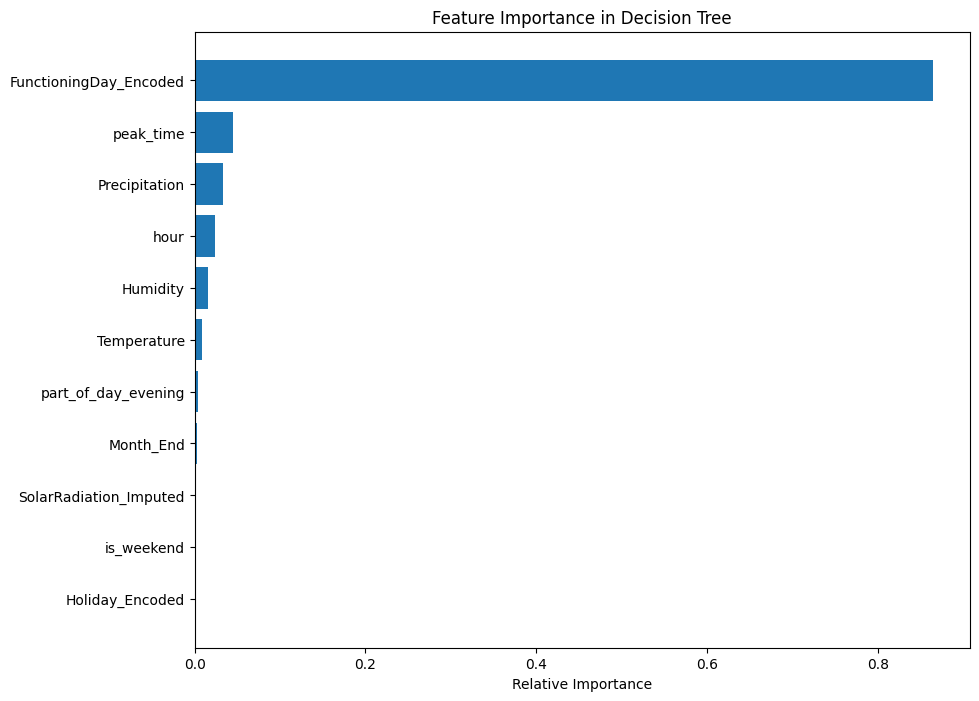

In [52]:
# Plot the graph
plot_decision_tree_feature_importances(x_train, y_train, decision_tree_best_params['best_params'])

The bar chart displays the relative importance of various features as determined by a Decision Tree Regressor model, with the purpose of understanding which factors most significantly influence bike rental volumes. 

__1. Functioning Day__: This is the most influential feature, dominating the chart. It suggests that whether a day is a functioning day for the bike-sharing system (probably reflecting whether the service is operational on that day) is the primary determinant of rental numbers.

__2. Peak Time__: The second most important feature, 'peak_time', highlights that the hours classified as peak time are critical in predicting rentals, which aligns with the expectation of higher demand during typical commuting hours.

__3. Weather Conditions__: 'Precipitation' and 'Humidity' are also significant but to a lesser extent. This indicates that adverse weather conditions have a notable but smaller impact on rental decisions compared to the operational status of the service and time of day.

__4. Time Factors__: The 'hour' feature shows moderate importance, implying that while peak times are crucial, the specific hour of the day also plays a role in rental frequency, potentially capturing finer-grained daily patterns.

5.'Temperature', 'part_of_day_evening', 'Month_Begin', and 'Month_End' have smaller bars, signifying these factors have some, but lesser, predictive power. Their presence confirms that environmental conditions and specific times within a day or month do influence rental behavior, albeit to a smaller degree.

6.Interestingly, 'is_weekend' and 'Holiday_Encoded' are less impactful according to this model. This could suggest that while such days might have different patterns of usage, they are not as significant as whether the day is operational ('FunctioningDay_Encoded') and what time it is ('peak_time').

Overall, this feature importance graph from the Decision Tree provides clear guidance on which aspects of the data are most valuable for predicting bike rental volumes, and can inform the prioritization of business strategies and model refinement.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> CONCLUSION </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

1. The analysis employed machine learning to predict bike rental demand with notable precision, using a dataset enriched with variables like weather conditions, time stamps, and bike usage. The Decision Tree model emerged as a standout amongst other models. 

2. The case identified 'FunctioningDay', 'peak_time', weather-related variables ('Precipitation', 'Humidity'), and temporal features ('hour', 'is_weekend') as significant predictors of rental volumes. 

3. The findings highlight how weather conditions and specific time frames significantly affect bike rental patterns. Notably, precipitation and humidity were found to inversely affect rental demand, illustrating the necessity for the bike-sharing program to adapt to Chicago's diverse weather landscape. Moreover, the analysis of peak hours (7 AM to 9 PM) versus non-peak hours presented clear patterns of usage, with peak times experiencing higher demand, thereby informing strategic bike distribution.

4. Based on the model's insights, I recommend targeted strategies for bike redistribution during peak demand times, weather-adaptive service planning. Also, the project sets a foundational framework for integrating real-time data and exploring more sophisticated algorithms to refine the predictive model.

5. Beyond its immediate implications for Chicago, this project serves as a blueprint for other cities aiming to harness data analytics for urban mobility optimization. The methodology and insights offer a replicable model for leveraging predictive analytics to enhance bike-sharing programs globally, contributing to the broader goals of urban sustainability and efficient transportation networks.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<div style="text-align: center; font-size: 24px;"><b> REFERENCES </b></div>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

OpenAI. (2024). Guidance on adding a trend line to a graph of average bike rentals by part of the month. ChatGPT. <br/>
OpenAI. (2024). Guidance on annotating scatterplots with correlation coefficients. ChatGPT. <br/>
OpenAI. (2024). Magnus formula for dew point temperature calculation and imputation. ChatGPT. <br/>